## Models for fraud detection

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Patricia Llull\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print ("LOADING DATASETS...")
df = pd.read_csv("dev.csv") 
dfo = pd.read_csv("oot0.csv")

LOADING DATASETS...


In [3]:
ibs = [var for var in df.columns if 'ib' in var]
icos =[feature for feature in df.columns if 'ico' in feature]
icns = [feature for feature in df.columns if 'icn' in feature]
ifss =[feature for feature in df.columns if 'if' in feature]
#dfo[ibs].isna().sum()
#dfo[icns].isna().sum() 
#dfo[ifss].isna().sum()
#dfo[icos].isna().sum() 

In [4]:
print ("DOING MY TRANSFORMATIONS...")

dfo[icns] = dfo[icns].fillna(1) 
dfo[ifss] = dfo[ifss].fillna(dfo.median())
dfo[ibs]  = dfo[ibs].fillna(dfo[ibs].median()).astype('int')
dfo[icos] = dfo[icos].fillna(dfo[icos].median())

DOING MY TRANSFORMATIONS...


In [124]:
print("STEP 1: NORMALISING AND DUMMIFYING VARIABLES...")
#min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()
scaler.fit(df[icos])

df[icos] = scaler.transform(df[icos])
#df[icos]

scaler2= MinMaxScaler()
scaler2.fit(df[ifss])

df[ifss] = scaler2.transform(df[ifss])
#df[ifss]

#apply transformations to oot

dfo[icos] = scaler.transform(dfo[icos])
#dfo[icos]
dfo[ifss] = scaler2.transform(dfo[ifss])
#dfo[ifss]

STEP 1: NORMALISING AND DUMMIFYING VARIABLES...


In [125]:
# dummies
for varname in icns:
    df_temp = pd.get_dummies(df[varname])
    new_dummy_names = []
    for colname in df_temp.columns:
        new_dummy_names.append(str(varname)+'_'+str(colname))
    df_temp.columns = new_dummy_names
    df = pd.concat([df,df_temp], axis=1)
    
dfo[icns] = dfo[icns].astype('int')

In [126]:
for varname in icns:
    df_temp = pd.get_dummies(dfo[varname])
    new_dummy_names = []
    for colname in df_temp.columns:
        new_dummy_names.append(str(varname)+'_'+str(colname))
    df_temp.columns = new_dummy_names
    dfo = pd.concat([dfo,df_temp], axis=1)

In [127]:
print ("STEP 2: SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL...")
# here we are also selecting the dummies we created so there are more variables than initially
features_model = [feature for feature in df.columns if 'ib_var_12' not in feature and 'id' not in feature and 'target' not in feature]

in_model = features_model
output_var = 'ob_target'

STEP 2: SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL...


In [128]:
from sklearn.cluster import KMeans
#do a kmeans without id and ib_12 and target,
#add the result as a new column
# do for both teh dev and oot datasets


X= df[features_model]
y = df['ob_target']
Xo = dfo[features_model]

KM = KMeans(random_state=0, n_clusters= 15) 
KM.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [129]:
labels_df= pd.DataFrame(KM.labels_)
labels_df.columns= ['group']
df = pd.concat([df,labels_df],axis=1)

In [130]:
labels_dfo= pd.DataFrame(KM.predict(Xo))

In [131]:
labels_dfo.columns = ['group']
dfo = pd.concat([dfo,labels_dfo], axis=1)

In [132]:
features_model = [feature for feature in df.columns if 'ib_var_12' not in feature and 'id' not in feature and 'target' not in feature]

In [133]:
print ("STEP 3: DEVELOPING THE MODEL...")
from sklearn.ensemble import RandomForestClassifier
X= df[features_model]
y = df['ob_target']
Xo = dfo[features_model]

clf = RandomForestClassifier(max_depth = 40, max_features = 'auto', n_estimators = 990, criterion = 'gini', class_weight='balanced', random_state = 0)
fitted_model = clf.fit(X, y)
pred_dev = fitted_model.predict_proba(X)[:,1]
pred_oot = fitted_model.predict_proba(Xo)[:,1]

clf.n_classes_

STEP 3: DEVELOPING THE MODEL...


2

## Feature Selection 
### Feature importance

Selected features seem to have each a small importance, there are no features that really stand out. We will try features selection.

In [134]:
array_scores = sorted(zip(map(lambda x: round(x, 3), clf.feature_importances_), features_model), reverse=True)
print("Features sorted by their score:")
array_scores

Features sorted by their score:


[(0.052, 'if_var_79'),
 (0.048, 'if_var_68'),
 (0.044, 'if_var_65'),
 (0.04, 'if_var_78'),
 (0.038, 'if_var_69'),
 (0.032, 'if_var_67'),
 (0.03, 'ico_var_36'),
 (0.025, 'ico_var_34'),
 (0.024, 'if_var_77'),
 (0.023, 'if_var_76'),
 (0.022, 'if_var_75'),
 (0.022, 'if_var_71'),
 (0.021, 'if_var_80'),
 (0.021, 'if_var_73'),
 (0.021, 'ico_var_35'),
 (0.021, 'ico_var_33'),
 (0.021, 'group'),
 (0.02, 'if_var_72'),
 (0.016, 'if_var_81'),
 (0.012, 'ico_var_53'),
 (0.012, 'ico_var_41'),
 (0.011, 'if_var_74'),
 (0.011, 'ico_var_55'),
 (0.011, 'ico_var_52'),
 (0.011, 'ico_var_47'),
 (0.011, 'ico_var_45'),
 (0.011, 'ico_var_37'),
 (0.011, 'ico_var_31'),
 (0.01, 'ico_var_63'),
 (0.01, 'ico_var_62'),
 (0.01, 'ico_var_61'),
 (0.01, 'ico_var_59'),
 (0.01, 'ico_var_51'),
 (0.01, 'ico_var_48'),
 (0.01, 'ico_var_42'),
 (0.01, 'ico_var_40'),
 (0.01, 'ico_var_39'),
 (0.01, 'ico_var_29'),
 (0.01, 'ico_var_27'),
 (0.009, 'if_var_70'),
 (0.009, 'ico_var_58'),
 (0.009, 'ico_var_56'),
 (0.009, 'ico_var_54'),
 (0

In [135]:
scores_df = pd.DataFrame(array_scores)
good_scores = scores_df[scores_df[0]>0.006]
new_features=[feature for feature in good_scores[1]]
len(new_features)

56

In [136]:
from sklearn.ensemble import RandomForestClassifier
X= df[new_features]
y = df['ob_target']
Xo = dfo[new_features]

clf = RandomForestClassifier(max_depth = 20, max_features = 'auto', n_estimators = 900, criterion = 'gini', class_weight='balanced', random_state = 0)
fitted_model = clf.fit(X, y)
pred_dev = fitted_model.predict_proba(X)[:,1]
pred_oot = fitted_model.predict_proba(Xo)[:,1]

clf.n_classes_ 

2

In [137]:
print ("STEP 4: ASSESSING THE MODEL...")
# CALCULATING GINI PERFORMANCE ON DEVELOPMENT SAMPLE
from sklearn.metrics import roc_auc_score
gini_score = 2*roc_auc_score(y, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

def KS(b,a):  
    """Function that received two parameters; first: a binary variable representing 0=good and 1=bad, 
    and then a second variable with the prediction of the first variable, the second variable can be continuous, 
    integer or binary - continuous is better. Finally, the function returns the KS Statistics of the two lists."""
    try:
        tot_bads=1.0*sum(b)
        tot_goods=1.0*(len(b)-tot_bads)
        elements = zip(*[a,b])
        elements = sorted(elements,key= lambda x: x[0])
        elements_df = pd.DataFrame({'probability': b,'gbi': a})
        pivot_elements_df = pd.pivot_table(elements_df, values='probability', index=['gbi'], aggfunc=[sum,len]).fillna(0)
        max_ks = perc_goods = perc_bads = cum_perc_bads = cum_perc_goods = 0
        for i in range(len(pivot_elements_df)):
            perc_goods =  (pivot_elements_df.iloc[i]['len'] - pivot_elements_df.iloc[i]['sum']) / tot_goods
            perc_bads = pivot_elements_df.iloc[i]['sum']/ tot_bads
            cum_perc_goods += perc_goods
            cum_perc_bads += perc_bads
            A = cum_perc_bads-cum_perc_goods
            if abs(A['probability']) > max_ks:
                max_ks = abs(A['probability'])
    except:
        max_ks = 0
    return max_ks


KS_score = KS(y,pred_dev)
print ("KS DEVELOPMENT=", KS_score) 

STEP 4: ASSESSING THE MODEL...
GINI DEVELOPMENT= 1.0
KS DEVELOPMENT= 0.9999999999999976


In [138]:
print ("STEP 5: SUBMITTING THE RESULTS...")
import requests
from requests.auth import HTTPBasicAuth
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
dfo_tosend=dfo_tosend.sort_values(by='id')
#change at every iteration to save all results separately
i=38
filename = "patricia_llull"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')

url = 'http://mfalonso.pythonanywhere.com/api/v1.0/uploadpredictions'

STEP 5: SUBMITTING THE RESULTS...


In [139]:
# remove the # below to submit
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('pati.llull', '*********'))

resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

RESULT SUBMISSION:  KS2 = 0.389047033706; GINI = 0.514623517777; GRADE = 9.219


## Chi-square

Looking at the plot, we can see some variables matter more. We will try to see if the model is improved by using the recommended features. The 'group' variable seems to matter.


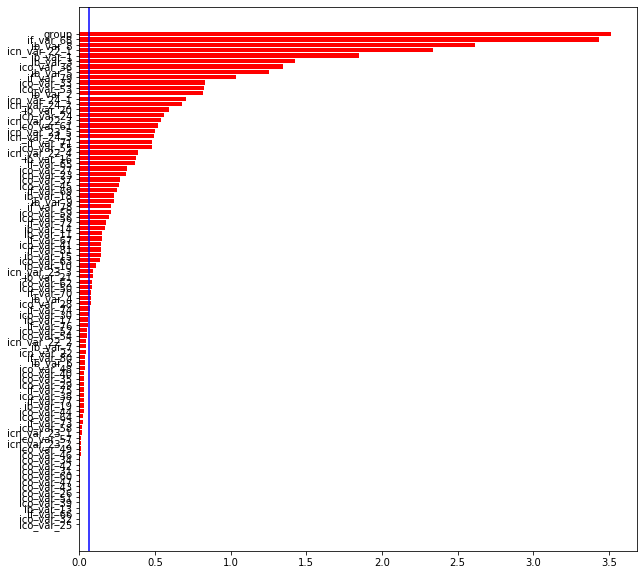

ChiSquared Threshold 0.06164674638718406


In [37]:
from sklearn.feature_selection import SelectKBest, chi2
from operator import itemgetter
from collections import defaultdict

chi2_selector = SelectKBest(score_func=chi2).fit(df.drop(['ob_target', 'ib_var_12', 'id'],axis=1), df['ob_target'])


# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = defaultdict(float)
for i in range(len(df.drop(['ob_target', 'ib_var_12', 'id'],axis=1).columns)):
    chi2_features[df.drop(['ob_target', 'ib_var_12', 'id'],axis=1).columns[indices[i]]] += chi2_selector.scores_[indices[i]]
    
items = sorted(chi2_features.items(), key=itemgetter(1), reverse=True)
keys, values = list(zip(*items))


plt.figure(figsize=(10,10))
plt.yticks(list(range(len(keys))), keys, rotation=0, fontsize=10)
plt.barh(list(range(len(keys))), values, color='r', align='center')
chi2_th = pd.Series(list(chi2_features.values())).quantile(0.25)*4
plt.axvline(chi2_th, color='blue')
plt.gca().invert_yaxis()

plt.show()

print("ChiSquared Threshold", chi2_th)

In [45]:
chi2_features_to_remove = dict(filter(lambda x: x[1] <= chi2_th, chi2_features.items())).keys()
print("Features to remove = {}".format(chi2_features_to_remove))

Features to remove = dict_keys(['ib_var_17', 'if_var_76', 'ico_var_52', 'ico_var_54', 'icn_var_22_2', 'ib_var_7', 'icn_var_22', 'if_var_80', 'ib_var_6', 'ico_var_48', 'ico_var_40', 'ico_var_35', 'ico_var_29', 'if_var_75', 'ico_var_38', 'if_var_77', 'ib_var_19', 'ico_var_44', 'ico_var_64', 'if_var_73', 'ico_var_58', 'icn_var_23_1', 'ico_var_57', 'icn_var_23_2', 'ico_var_49', 'ico_var_46', 'ico_var_34', 'ico_var_42', 'ico_var_31', 'ico_var_60', 'ico_var_47', 'ico_var_43', 'ico_var_26', 'ico_var_51', 'ico_var_39', 'ib_var_13', 'if_var_66', 'ico_var_32', 'ico_var_25'])


In [46]:
selected_features =[feature for feature in df.columns if 'ib_var_12' not in feature and 'id' not in feature and 'target' not in feature and feature not in chi2_features_to_remove]

In [111]:
X= df[selected_features]
y = df['ob_target']
Xo = dfo[selected_features]

clf = RandomForestClassifier(max_depth = 30, max_features = 'log2', n_estimators = 1000, criterion = 'gini', class_weight='balanced', random_state = 0)
fitted_model = clf.fit(X, y)
pred_dev = fitted_model.predict_proba(X)[:,1]
pred_oot = fitted_model.predict_proba(Xo)[:,1]

In [112]:
print ("STEP 4: ASSESSING THE MODEL...")
# CALCULATING GINI PERFORMANCE ON DEVELOPMENT SAMPLE
from sklearn.metrics import roc_auc_score
gini_score = 2*roc_auc_score(y, pred_dev)-1
print ("GINI DEVELOPMENT=", gini_score)

def KS(b,a):  
    """Function that received two parameters; first: a binary variable representing 0=good and 1=bad, 
    and then a second variable with the prediction of the first variable, the second variable can be continuous, 
    integer or binary - continuous is better. Finally, the function returns the KS Statistics of the two lists."""
    try:
        tot_bads=1.0*sum(b)
        tot_goods=1.0*(len(b)-tot_bads)
        elements = zip(*[a,b])
        elements = sorted(elements,key= lambda x: x[0])
        elements_df = pd.DataFrame({'probability': b,'gbi': a})
        pivot_elements_df = pd.pivot_table(elements_df, values='probability', index=['gbi'], aggfunc=[sum,len]).fillna(0)
        max_ks = perc_goods = perc_bads = cum_perc_bads = cum_perc_goods = 0
        for i in range(len(pivot_elements_df)):
            perc_goods =  (pivot_elements_df.iloc[i]['len'] - pivot_elements_df.iloc[i]['sum']) / tot_goods
            perc_bads = pivot_elements_df.iloc[i]['sum']/ tot_bads
            cum_perc_goods += perc_goods
            cum_perc_bads += perc_bads
            A = cum_perc_bads-cum_perc_goods
            if abs(A['probability']) > max_ks:
                max_ks = abs(A['probability'])
    except:
        max_ks = 0
    return max_ks


KS_score = KS(y,pred_dev)
print ("KS DEVELOPMENT=", KS_score) 

STEP 4: ASSESSING THE MODEL...
GINI DEVELOPMENT= 1.0
KS DEVELOPMENT= 0.9999999999999992


In [113]:
print ("STEP 5: SUBMITTING THE RESULTS...")
import requests
from requests.auth import HTTPBasicAuth
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
dfo_tosend=dfo_tosend.sort_values(by='id')
i=56
filename = "patricia_llull"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')

url = 'http://mfalonso.pythonanywhere.com/api/v1.0/uploadpredictions'

STEP 5: SUBMITTING THE RESULTS...


In [116]:
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('pati.llull', '*********'))

resp_str = str(rsub.text)
print ("RESULT SUBMISSION: ", resp_str)

RESULT SUBMISSION:  KS2 = 0.398849573471; GINI = 0.538567824102; GRADE = 9.451


## Final Model

We select the Random Forest with Chi-square selection of features for two reasons:
- it is less random than simply selecting the 'overall importance of values' with get_features_importances
- it yields better results.